## UNSW-NB15: Exploratory Data Analysis

# Loading data from disk

In [1]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting
from scipy import stats

import pickle  # To load data int disk
from prettytable import PrettyTable  # To print in tabular format

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.metrics import auc, f1_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict

%matplotlib inline

In [2]:
train = pd.read_csv('./train_alldata_EDA.csv')
test = pd.read_csv('./test_alldata_EDA.csv')

In [3]:
train.shape, test.shape

((1778032, 49), (762015, 49))

In [4]:
# Dividing the train data into attack and non-attack category
normal = train[train['label']==0]
anomaly = train[train['label']==1]

## Correlation

## Utility functions

In [5]:
def multi_corr(col1, col2="label", df=train):
    '''
    This function returns correlation between 2 given features.
    Also gives corr of the given features with "label" afetr applying log1p to it.
    '''
    corr = df[[col1, col2]].corr().iloc[0,1]
    log_corr = df[col1].apply(np.log1p).corr(df[col2])

    print("Correlation : {}\nlog_Correlation: {}".format(corr, log_corr))

In [6]:
def corr(col1, col2="label", df=train):
    """
    This function returns correlation between 2 given features
    """
    return df[[col1, col2]].corr().iloc[0,1]

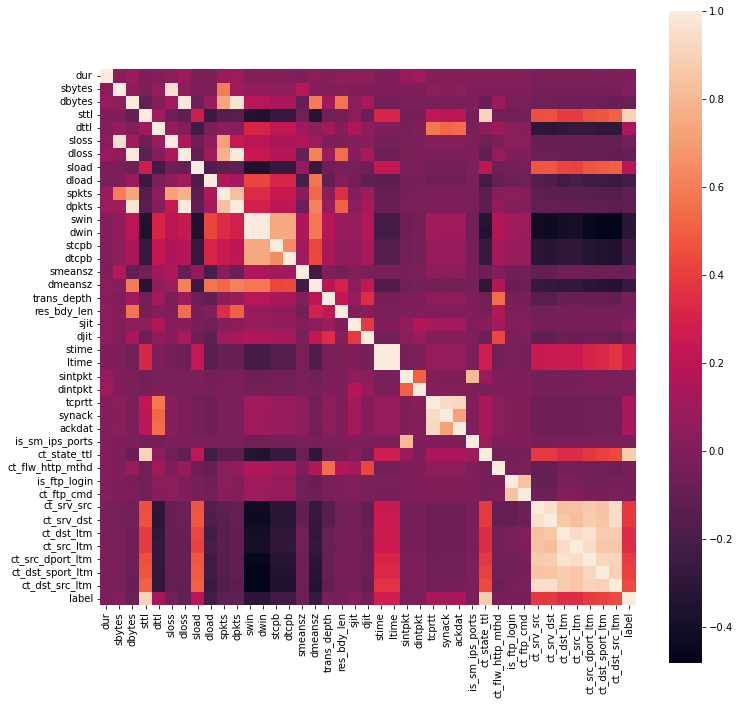

In [7]:
# Plotting the correlation matrix of the dataset
# Refer: https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf

method = "pearson"
# correlation matrix
corr_mat = train.corr(method=method)

plt.figure(figsize=(12,12)) 
sns.heatmap(corr_mat, square=True)
plt.show()

In [8]:
# Getting and printing high correlated features
limit = 0.9

columns = corr_mat.columns
for i in range(corr_mat.shape[0]):
    for j in range(i+1, corr_mat.shape[0]):
        if corr_mat.iloc[i, j] >= 0.9:
            print(f"{columns[i]:20s} {columns[j]:20s} {corr_mat.iloc[i, j]}")

sbytes               sloss                0.9515464133660682
dbytes               dloss                0.9912941785427634
dbytes               dpkts                0.9705744719061106
sttl                 ct_state_ttl         0.9058027624589845
sttl                 label                0.9043459910087561
dloss                dpkts                0.9921743916746946
swin                 dwin                 0.9971933359586712
stime                ltime                0.9999999998073185
tcprtt               synack               0.9332414134584021
tcprtt               ackdat               0.9202047490089745
ct_srv_src           ct_srv_dst           0.956721026945663
ct_srv_src           ct_dst_src_ltm       0.942148711061324
ct_srv_dst           ct_dst_src_ltm       0.9510250540010916
ct_dst_ltm           ct_src_ltm           0.9384612565049639
ct_dst_ltm           ct_src_dport_ltm     0.9601144948755526
ct_src_ltm           ct_src_dport_ltm     0.9453045008443021
ct_src_dport_ltm     ct_ds

## Pairplots of highly correlated features

## sbytes and sloss
1. These features are having very high corr between them more 95%
2. All the features are following a straight line except for the starting points that means they are having incresing relation with each other.

## sttl, ct_state_ttl, label
1. sttl and ct_state_ttl are having 90% correlation between them.

But one important thing to notice that these 2 features are also highly correlated with target features i.e, label.

Going to drop 1 feature, and the remaining feature could play a vital role for the classification task.

## tcprtt, synack and ackdat
synack: The time between the SYN and the SYN_ACK packets of the TCP.
ackdat: The time between the SYN_ACK and the ACK ackets of the TCP.
tcprtt: sum of above 2 columns.

1. There are some similarity between "tcprtt" and "synack" and "tcsprtt" and "actdat" as value of x increases value of y also increases.
2. But for "synack" and "ackdat" values are scattered all over. And its corr value also not over 90%

## ct_srv_src, ct_srv_dst and ct_dst_src_ltm
1. Range of all the features are between 0 to 60.
2. Most of the values are close to 0 and less than 10.
3. Values are well scattered but there are clear line that means have some linear relationship.

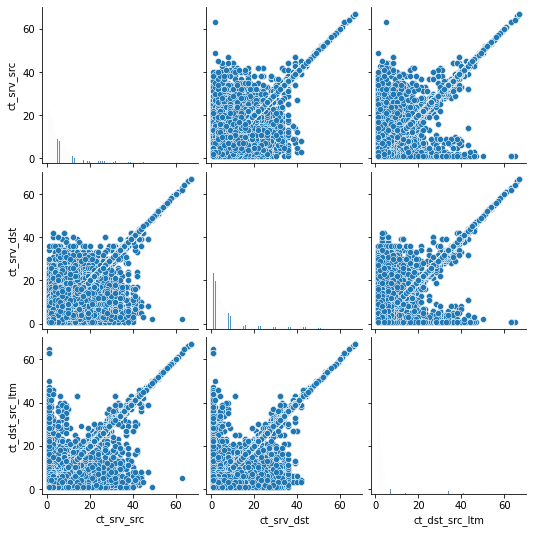

In [9]:
sns.pairplot(train, vars=['ct_srv_src', 'ct_srv_dst', 'ct_dst_src_ltm'])
plt.show()

## ct_dst_ltm, ct_src_ltm, ct_src_dport_ltm and ct_dst_sport_ltm
1. values range from 0 to 60.
2. Most of the values are close to 0 and lesser than 20.
3. ct_dst_ltm highly corr with ct_dst_sport_ltm
4. ct_src_ltm corr with ct_src_dport_ltm
5. ct_src_dport_ltm corr with ct_dst_sport_ltm

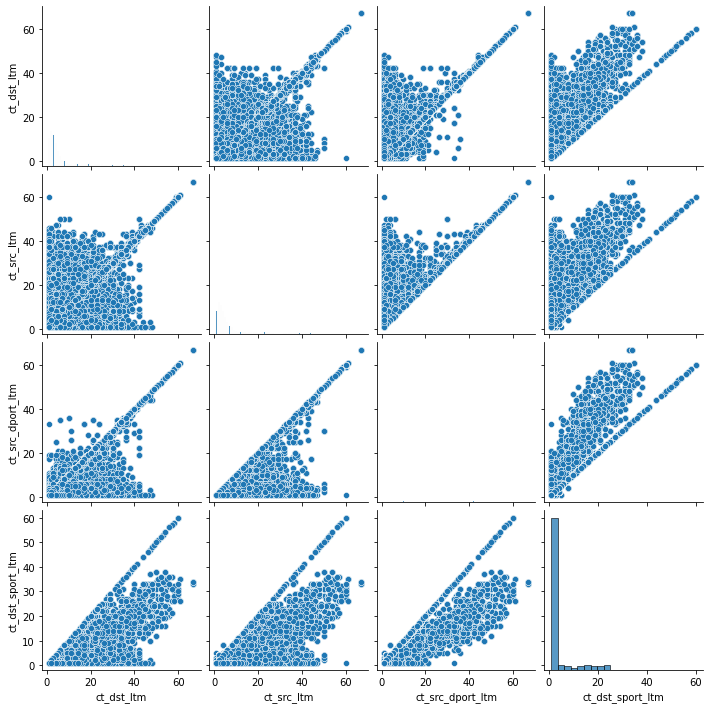

In [10]:
sns.pairplot(train, vars=['ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm'])
plt.show()

## Countplots and pdf of features

In [11]:
def col_countplot(col, train_data=train):
    """
    This function plots countplot of a given feature for train dataset
    """
    fig, ax = plt.subplots(figsize=(8,4))
    sns.set_style('whitegrid')
    # countplot of the given column
    ax = sns.countplot(x=col, hue='label', data=train_data)
    ax.legend(loc="upper right", labels=('normal', 'attack'))
    ax.set_title("train data")
    plt.xticks(rotation=45)
    plt.show()

In [12]:
# Plotting pdf of numerical columns
# Refer: https://www.kaggle.com/khairulislam/unsw-nb15-eda

def dual_plot(col, data1=normal, data2=anomaly, label1='normal', label2='anomaly', method=None):
    """
    This function plots pdf of the given feature on attack and non-attck data
    """
    if method != None:
        sns.set_style('whitegrid')
        sns.distplot(data1[col].apply(method), label=label1, hist=False, rug=True)
        sns.distplot(data2[col].apply(method), label=label2, hist=False, rug=True)
    else:
        sns.set_style('whitegrid')
        sns.distplot(data1[col], label=label1, hist=False, rug=True)
        sns.distplot(data2[col], label=label2, hist=False, rug=True)
    plt.legend()

In [13]:
def reduce_column(s, to_keep):
    """
    This function reduce categorical values of a given feature to values provided in to_keep list
    and make every other value "others"
    """
    s = s.lower().strip()
    if s not in to_keep:
        return "others"
    else:
        return s

## Attack Category
The name of each attack category. In this data set, there are total nine categories of attack and normal is non-attack.

The data is highly imbalanced and have lots of non-attack than attacks.

In train data most occured attack data categories are "Generic", "Exploits", Fuzzers", "DoS" and "Reconnaissance"

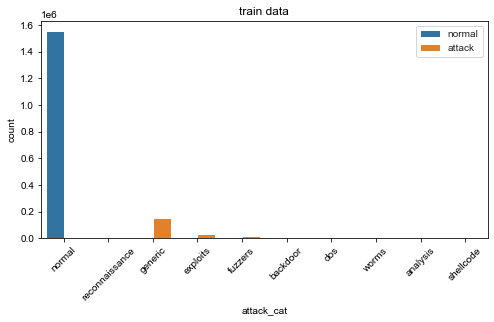

In [14]:
col_countplot('attack_cat')

## Proto
Categorical feature. Transaction protocol

The no of unique values of 'proto' in dataset where attack is normal is 7 but in anamoly category its 129. So to plot it we are reducing the no of values.
Most of the values are consists of udp and tcp
For non-attacks count of tcp is lot higher
Considering the imbalce there are lots of udp cat for attacks

In [15]:
train['proto'].nunique()

135

In [16]:
normal['proto'].nunique(), anomaly['proto'].nunique()

(9, 129)

In [17]:
train['proto'].value_counts().head(10)*100/train.shape[0]

tcp     58.858108
udp     38.983550
unas     0.639640
arp      0.397631
ospf     0.306800
sctp     0.061810
icmp     0.020303
any      0.015916
gre      0.013104
ipv6     0.011642
Name: proto, dtype: float64

In [18]:
to_keep = ['tcp', 'udp', 'unas', 'arp', 'ospf']
train['proto_reduced'] = train['proto'].apply(reduce_column, args=(to_keep,))

## Service
Categorical Features

1. In our dataset we can value "-" that is null, we need to remove that and replace it.
2. For normal there are lots of others that means most of "-" and few rare values.
3.In attack data "dns" is present higher than any other values. There are few no of others and http also.

In [19]:
train['service'].nunique()

13

In [20]:
train['service'].value_counts()

None        872286
dns         547094
http        144555
ftp-data     88310
smtp         57160
ftp          34293
ssh          32897
pop3          1076
dhcp           124
ssl            109
snmp            81
radius          27
irc             20
Name: service, dtype: int64

In [21]:
to_keep = ['dns', 'http', 'smtp', 'ftp-data', 'ftp', 'ssh', 'pop3']
train['service_reduced'] = train['service'].apply(reduce_column, args=(to_keep,))

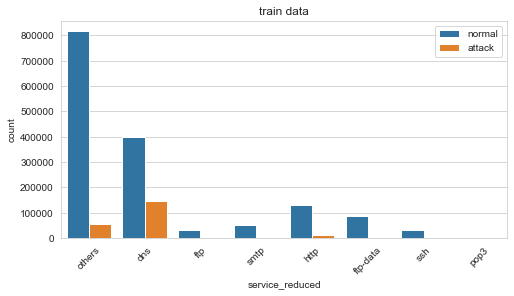

In [22]:
col_countplot('service_reduced')

## State
Categorical feature. The state and its dependent protocol

Reducing very rare values with "others" to plot and visualize better

1. For non-attacks "fin" is very frequent then "cons" almost half of "fin" and few "int" also.
2. In attack "int" is higher than normal cat values. That could be really important feature to detect. There are very few "fin"

In [23]:
train['state'].nunique()

16

In [24]:
train['state'].value_counts()

FIN    1034981
CON     392422
INT     343397
REQ       6361
RST        368
ECO        227
CLO        108
URH         78
ACC         34
PAR         20
TST          8
URN          7
ECR          7
no           6
TXD          4
MAS          4
Name: state, dtype: int64

In [25]:
to_keep = ['int', 'fin', 'con', 'req']
train['state_reduced'] = train['state'].apply(reduce_column, args=(to_keep,))


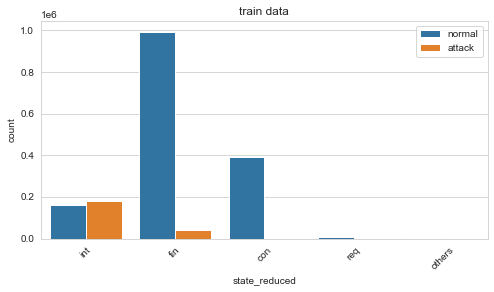

In [26]:
col_countplot('state_reduced')

In [27]:
train.drop(columns=['proto_reduced', 'state_reduced', 'service_reduced'], inplace=True)

In [28]:
train.shape

(1778032, 49)